In [1]:
import cv2
import numpy as np
import os, sys, platform
import traceback
import math
import time
import sim
import PIL
import json
from PIL import Image
from IPython.display import display

## Global Variables:

In [2]:
#Non-editable:
client_id = -1
setpoint = [0, 0]
start_coord = (0,4)
end_coord = (9,5)

#Editable:
servo_handle1=0
servo_handle2=0
sum_err_x = 0
sum_err_y = 0
prev_time = 0
curr_time = 0
prev_center_x = 0
prev_center_y = 0
target_angle_x = 0
target_angle_y = 0
client_id = -1
setpoint = [640, 640]
vision_sensor_handle = 0
overshot_x = 0
overshot_y = 0
prev_setpoint = [0,0]

## ------------------------------------------------------------------------------------------------------------------------------------

# Task 1A Part 1:

### scan_image(warped_image)

In [3]:
def scan_image(warped_image):

    """
    Purpose:
    ---
    this function takes file path of an image as an argument and returns dictionary
    containing details of colored (non-white) shapes in that image

    Input Arguments:
    ---
    `img_file_path` :		[ str ]
        file path of image

    Returns:
    ---
    `shapes` :              [ dictionary ]
        details of colored (non-white) shapes present in image at img_file_path
        { 'Shape' : ['color', Area, cX, cY] }
    
    Example call:
    ---
    shapes = scan_image(img_file_path)
    """

    global shapes

    ##############	ADD YOUR CODE HERE	##############
	
    
     #Convert Grayscale Image to Binary:
    bin_img=cv2.threshold(warped_image, 245, 255, type=cv2.THRESH_BINARY)
    bin_img=bin_img[1]
    
    #Detect Contours in the Binary Image, each contour represents perimeter of each shape detected:
    contours=cv2.findContours(bin_img,1,2)
    contours=contours[0]
    
    #Initializing the dictionary shapes:
    shapes={}
    
    if len(contours) is 0:
        return shapes
    
    #Initializing a list to store the values before sorting with respect to area
    unsorted_shapes=[]
    
    #For Loop that iterates through each contour(shape) detected except the last one since the last one is the boundary of the entire image itself    
    for cont in contours[:-1]:
        
        #Finding the coordinates of each vertex of the shape detected and storing it in the array points:
        points=cv2.approxPolyDP(cont, 0.01*cv2.arcLength(cont,True), True)
        #n = No. of vertices
        n=len(points)
        
        #Initializing centroid coordinates as (0,0)
        cX=0
        cY=0
        
        #Iterating through each point detected and adding its X and Y coordinates
        for p in points:
            cY=cY+p[0][1]
            cX=cX+p[0][0]
            
        #Dividing the total sum of X,Y coordinates by the number of points to find the centroid coordinates
        cX=cX//n
        cY=cY//n
        
        #Detecting the colour code at the centroid of the shape, then finding out its colour:
        #b,g,r=warped_image[cY, cX]
        #if g<r and b<r:
        #    colour="red"
        #elif r<g and b<g:
        #    colour="green"
        #elif r<b and g<b:
        #    colour="blue"
        #else:
        colour="black"
            
        #Considering a polygon of n sides, it can be divided into n triangles by connecting each vertex to the centroid
        #Area of the polygon can be calculated by finding the area of each triangle using Heron's Formula and then adding the area of each triangle up.
        
        #Initializing a list sides to contain all the side lengths:
        sides=[]
        #Initializing a list radii to contain the distances from the centroid to each vertex:
        radii=[]
        
        #Filling up sides and radii with distance values:
        for i in range(n-1):
            sides.append((((points[i][0][0]-points[i+1][0][0])**2)+((points[i][0][1]-points[i+1][0][1])**2))**0.5)
            radii.append(((((points[i][0][0]-cX)**2)+(points[i][0][1]-cY)**2)**0.5))
        sides.append((((points[0][0][0]-points[n-1][0][0])**2)+((points[0][0][1]-points[n-1][0][1])**2))**0.5)
        radii.append(((((points[n-1][0][0]-cX)**2)+(points[n-1][0][1]-cY)**2)**0.5))
        
        #Initialize area as zero:
        area=0
        
        #Iterate through each triangle that the polygon has been divided into and accumulating the area of each triangle:
        for i in range(n):
            j=i+1
            if j==n:
                j=0
            #Applying Heron's Formula:
            peri=(sides[i]+radii[i]+radii[j])/2
            area=area+(peri*(peri-sides[i])*(peri-radii[i])*(peri-radii[j]))**0.5
            
        #DETECTING THE SHAPE:
        
        if n==3:
            shape="Triangle"
            #If the shape is already a triangle, we can calculate its area directly from each side length using heron's formula for higher accuracy
            #Note: each side length is multiplied 1.01 because there is a +1% error observed in the coordinates detected by approxPolyDP function
            a=((((points[0][0][0]-points[1][0][0])**2)+((points[0][0][1]-points[1][0][1])**2))**0.5)*1.01
            b=((((points[1][0][0]-points[2][0][0])**2)+((points[1][0][1]-points[2][0][1])**2))**0.5)*1.01
            c=((((points[2][0][0]-points[0][0][0])**2)+((points[2][0][1]-points[0][0][1])**2))**0.5)*1.01
            peri=(a+b+c)/2
            area=(peri*(peri-a)*(peri-b)*(peri-c))**0.5
            
            
        elif n==4:
            #The shape is detected to be a quadrilateral,
            #Calculating length of each side:
            a=(((points[0][0][0]-points[1][0][0])**2)+((points[0][0][1]-points[1][0][1])**2))**0.5
            b=(((points[1][0][0]-points[2][0][0])**2)+((points[1][0][1]-points[2][0][1])**2))**0.5
            c=(((points[2][0][0]-points[3][0][0])**2)+((points[2][0][1]-points[3][0][1])**2))**0.5
            d=(((points[3][0][0]-points[0][0][0])**2)+((points[3][0][1]-points[0][0][1])**2))**0.5
            
            #Calculating the length of diagonals:
            diag1=(((points[0][0][0]-points[2][0][0])**2)+((points[0][0][1]-points[2][0][1])**2))**0.5
            diag2=(((points[1][0][0]-points[3][0][0])**2)+((points[1][0][1]-points[3][0][1])**2))**0.5
            
            #Checking if all angles are 90 degrees using (side1)^2 + (side2)^2 = diagonal^2 i.e. Pythagoras Theorem
            if (abs((a*a+b*b)-(diag1*diag1))**0.5)<20 and (abs((b*b+c*c)-(diag2*diag2))**0.5)<20 and (abs((c*c+d*d)-(diag1*diag1))**0.5)<20:
                #Checking if adjacent sides are equal:
                if abs(a-d)<=2:
                    shape="Square"
                else:
                    shape="Rectangle"
                    
            #Checking all sides are equal:
            elif abs(a-b)<2 and abs(b-c)<2 and abs(c-d)<2:
                shape="Rhombus"
            else: 
                #Checking if opposite sides are equal:
                if abs(a-c)<2 and abs(b-d)<2:
                    shape="Parallelogram"
                else:
                    shape="Quadrilateral"
                    
        #For a circle, we cannot calculate area by dividing into triangles,
        #So, we take the average radius from radii list we made earlier and use it to calculate area
        else:
            shape="Circle"
            radius=sum(radii)/n
            area=3.14*radius*radius
        
        #Rounding the value of area to one decimal
        area=round(area,1)
        
        #Inserting the values obtained into the unsorted list:
        unsorted_shapes.append((shape, colour , cX, cY))
    
    
    #Sorting the list with respect to decreasing area using bubble sort:
    n=len(unsorted_shapes)
    for i in range(n):
        for j in range(n-i-1):
            if unsorted_shapes[j]>unsorted_shapes[j+1]:
                temp=unsorted_shapes[j]
                unsorted_shapes[j]=unsorted_shapes[j+1]
                unsorted_shapes[j+1]=temp
    
    #Finally, inserting the sorted values in the dictionary:
    new_array_created=0
    for i in range(n):
        if unsorted_shapes[i][0] not in shapes:
            shapes[unsorted_shapes[i][0]]=[unsorted_shapes[i][1], unsorted_shapes[i][2], unsorted_shapes[i][3]]
        elif new_array_created==0:
            shapes[unsorted_shapes[i][0]]=[shapes[unsorted_shapes[i][0]]]
            shapes[unsorted_shapes[i][0]].append([unsorted_shapes[i][1], unsorted_shapes[i][2], unsorted_shapes[i][3]])
            new_array_created=1
        else:
            shapes[unsorted_shapes[i][0]].append([unsorted_shapes[i][1], unsorted_shapes[i][2], unsorted_shapes[i][3]])
    
	##################################################
    
    return shapes

<>:41: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:41: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-3-b08cbbc145f5>:41: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(contours) is 0:


## ------------------------------------------------------------------------------------------------------------------------------------

# Task 1B:

### applyPerspectiveTransform(input_img):

In [4]:
def applyPerspectiveTransform(input_img):

    """
    Purpose:
    ---
    takes a maze test case image as input and applies a Perspective Transfrom on it to isolate the maze

    Input Arguments:
    ---
    `input_img` :   [ numpy array ]
        maze image in the form of a numpy array

    Returns:
    ---
    `warped_img` :  [ numpy array ]
        resultant warped maze image after applying Perspective Transform

    Example call:
    ---
    warped_img = applyPerspectiveTransform(input_img)
    """

    warped_img = None

    ##############    ADD YOUR CODE HERE    ##############
    
    #Converting image to grayscale
    gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)

    #Obtaining height and width of the image
    height, width = input_img.shape[:2]
    if (height, width)== (512,512):
       edged = cv2.Canny(gray, 30, 200)
    else:
      edged=cv2.threshold(gray, 245, 255, type=cv2.THRESH_BINARY)
      edged= edged[1]
    cv2.waitKey(0)


    #Finding conours of the image:
    contours = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    #If contours contains more than 1 array, concatenating these into a single array
    if len(contours) is 2:
      s1= len(contours[0])
      s2= len(contours[1])
      C= [[[0,0]] for i in range((s1+s2)) ]
      C= np.array(C)
      C= C.reshape((s1+s2), 2)
      cnt= contours[0]
      C= np.concatenate((contours[0], contours[1]))
    elif len(contours) is 3:
      s1= len(contours[0])
      s2= len(contours[1])
      s3= len(contours[2])
      C= [[[0,0]] for i in range((s1+s2+s3)) ]
      C= np.array(C)
      C= C.reshape((s1+s2+s3), 2)
      cnt= contours[0]
      C= np.concatenate((contours[0], contours[1], contours[2]))
    else:
      C= contours[0]

    #print(contours)
    #print(len(contours))
      
    epsilon = 0.05*cv2.arcLength(C,True)
    #Applying approxPolyDP() function to get desired contours
    approx = cv2.approxPolyDP(C,epsilon,True)
    print(approx)


    if (height, width)== (512,512):
    #Obtaining the 4 points to be used for perspective transform
      for i in range(len(approx)):
      #Eliminating points out of range
        if any(approx[i][0]>500):
           continue
      #Obtaining the lefmost top corner point
        if approx[i][0][0]<100:
          if approx[i][0][1]<100:
               a00= approx[i][0][0]
               a01= approx[i][0][1]
      #Obtaining the rightmost top corner point
        if approx[i][0][0]>400:
          if approx[i][0][1]<100:
            a10= approx[i][0][0]
            a11= approx[i][0][1]
      #Obtaining the rightmost bottom corner point
        if approx[i][0][0]>400:
          if approx[i][0][1]>400:
            a20= approx[i][0][0]
            a21= approx[i][0][1]
      #Obtaining the lefmost bottom corner point
        if approx[i][0][0]<100:
          if approx[i][0][1]>400:
            a30= approx[i][0][0]
            a31= approx[i][0][1]
    else:
        for i in range(len(approx)):
            if approx[i][0][0]<50:
                if approx[i][0][1]<50:
                    a00= approx[i][0][0]
                    a01= approx[i][0][1]
            if 800<approx[i][0][0]<1020:
                if approx[i][0][1]<50:
                    a10= approx[i][0][0]
                    a11= approx[i][0][1]
            if 800<approx[i][0][0]<1020:
                if 800<approx[i][0][1]<1020:
                    a20= approx[i][0][0]
                    a21= approx[i][0][1]
            if approx[i][0][0]<50:
                if 800<approx[i][0][1]<1020:
                    a30= approx[i][0][0]
                    a31= approx[i][0][1]
                    
    print(a00, a01, a10, a11, a20, a21, a30, a31)
    pts1 = np.float32([[a00, a01], [a10, a11], [a20, a21], [a30, a31]])
    pts2= np.float32([[0,0], [width,0],[width,height],[0,height]])
    #Applying perpective transform on the extreme points of the original image
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result= cv2.warpPerspective(input_img, matrix, (width, height))
    #Storing result as an array
    result= np.array(result)
    if (height, width)!= (512,512):
       result= cv2.resize(result,(1280, 1280))
    warped_img= result

    ##################################################

    return warped_img

<>:44: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:52: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:44: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:52: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-4-340aad59f972>:44: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(contours) is 2:
<ipython-input-4-340aad59f972>:52: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif len(contours) is 3:


### detectMaze(warped_img):

In [5]:
def detectMaze(warped_img):

    """
    Purpose:
    ---
    takes the warped maze image as input and returns the maze encoded in form of a 2D array

    Input Arguments:
    ---
    `warped_img` :    [ numpy array ]
        resultant warped maze image after applying Perspective Transform

    Returns:
    ---
    `maze_array` :    [ nested list of lists ]
        encoded maze in the form of a 2D array

    Example call:
    ---
    maze_array = detectMaze(warped_img)
    """

    maze_array = []

    ##############    ADD YOUR CODE HERE    ##############
    #Converting warped_image to grayscale
    gray1 = cv2.cvtColor(warped_img, cv2.COLOR_BGR2GRAY)

    #Obtaining height and width of image
    width= gray1.shape[0]
    height= gray1.shape[1]

    #Obtaining the height and width of each cell
    X = width//10
    Y = height//10

    #Initiallizing a 10x10 array of zeros
    A= [0 for i in range(100)]
    A= np.array(A)
    A= A.reshape(10, 10)
    x=0
    j=0
    y=0
    i=0

    #Loop to itterate through the height of the image
    while y<= height-Y+1:
        x=0
        j=0
        l1=[]
        l2=[]
        l3=[]
        l4=[]
        #Loop to itterate through the width of the image
        while x<= width-X+1:
           #Checking if the point is on the leftmost edge of the image
           if y==0:
             A[i][j]+= 2**0
           #Checking the midpoint of the left edge with a tolerance of 3 points on either side of the edge
           else:
             l1= [gray1[x+(X//2),y-3]<100,gray1[x+(X//2),y-2]<100,gray1[x+(X//2),y-1]<100,gray1[x+(X//2),y]<100,gray1[x+(X//2),y+1]<100,gray1[x+(X//2),y+2]<100,gray1[x+(X//2),y+3]<100]
             if any(l1):
                 A[i][j]+= 2**0
           #Checking if the point is on the topmost edge of the image
           if x==0:
              A[i][j]+= 2**1
           #Checking the midpoint of the top edge with a tolerance of 3 points on either side of the edge
           else:
              l2= [gray1[x-3,y+(Y//2)]<100,gray1[x-2,y+(Y//2)]<100,gray1[x-1,y+(Y//2)]<100,gray1[x,y+(Y//2)]<100,gray1[x+1,y+(Y//2)]<100,gray1[x+2,y+(Y//2)]<100,gray1[x+3,y+(Y//2)]<100]
              if any(l2):
                 A[i][j]+= 2**1
           #Checking if the point is on the righttmost edge of the image(y+Y*10=510)
           if y+Y== 510:
              A[i][j]+= 2**2
           #Checking the midpoint of the right edge with a tolerance of 3 points on either side of the edge
           else:
              l3= [gray1[x+(X//2),y+Y-3]<100,gray1[x+(X//2),y+Y-2]<100,gray1[x+(X//2),y+Y-1]<100,gray1[x+(X//2),y+Y]<100,gray1[x+(X//2),y+Y+1]<100,gray1[x+(X//2),y+Y+2]<100,gray1[x+(X//2),y+Y+3]<100]
              if any(l3):
                 A[i][j]+= 2**2
           #Checking if the point is on the bottommost edge of the image(x+X*10=510)
           if x+X== 510:
              A[i][j]+= 2**3
           #Checking the midpoint of the bottom edge with a tolerance of 3 points on either side of the edge
           else:
              l4= [gray1[x+X-3,y+(Y//2)]<100,gray1[x+X-2,y+(Y//2)]<100,gray1[x+X-1,y+(Y//2)]<100,gray1[x+X,y+(Y//2)]<100,gray1[x+X+1,y+(Y//2)]<100,gray1[x+X+2,y+(Y//2)]<100,gray1[x+X+3,y+(Y//2)]<100]
              if any(l4):
                 A[i][j]+= 2**3
           j+=1
           x+=X
        y+=Y
        i+=1
    #Obtaining the matrix in desired form
    A=np.transpose(A)
    #Converting array to a list
    maze_array= A.tolist()


    ##################################################

    return maze_array

## ------------------------------------------------------------------------------------------------------------------------------------

# Task 2A:

### init_remote_api_server():

In [6]:
def init_remote_api_server():

    """
    Purpose:
    ---
    This function should first close any open connections and then start
    communication thread with server i.e. CoppeliaSim.

    NOTE: In this Task, do not call the exit_remote_api_server function in case of failed connection to the server.
    The test_task_2a executable script will handle that condition.
    
    Input Arguments:
    ---
    None
    
    Returns:
    ---
    `client_id`     :  [ integer ]
        the client_id generated from start connection remote API, it should be stored in a global variable
    
    Example call:
    ---
    client_id = init_remote_api_server()
    
    NOTE: This function will be automatically called by test_task_2a executable before starting the simulation.
    """

    global client_id

    ##############    ADD YOUR CODE HERE    ##############
    
    sim.simxFinish(-1)
    client_id=sim.simxStart('127.0.0.1',19997,True,True,5000,5)

    ##################################################

    return client_id

### start_simulation():

In [7]:
def start_simulation():

    """
    Purpose:
    ---
    This function should first start the simulation if the connection to server
    i.e. CoppeliaSim was successful and then wait for last command sent to arrive
    at CoppeliaSim server end.

    NOTE: In this Task, do not call the exit_remote_api_server function in case of failed connection to the server.
    The test_task_2a executable script will handle that condition.
    
    Input Arguments:
    ---
    None
    
    Returns:
    ---
    `return_code`     :  [ integer ]
        the return code generated from the start running simulation remote API
    
    Example call:
    ---
    return_code = start_simulation()
    
    NOTE: This function will be automatically called by test_task_2a executable at the start of simulation.
    """

    global client_id

    return_code = 0

    ##############    ADD YOUR CODE HERE    ##############
    
    return_code=sim.simxStartSimulation(client_id, sim.simx_opmode_oneshot)

    ##################################################

    return return_code

### get_vision_sensor_image(vision_sensor_handle):

In [8]:
def get_vision_sensor_image(vision_sensor_handle):
    
    """
    Purpose:
    ---
    This function should first get the handle of the Vision Sensor object from the scene.
    After that it should get the Vision Sensor's image array from the CoppeliaSim scene.

    Input Arguments:
    ---
    None
    
    Returns:
    ---
    `vision_sensor_image`     :  [ list ]
        the image array returned from the get vision sensor image remote API
    `image_resolution`         :  [ list ]
        the image resolution returned from the get vision sensor image remote API
    `return_code`             :  [ integer ]
        the return code generated from the remote API
    
    Example call:
    ---
    vision_sensor_image, image_resolution, return_code = get_vision_sensor_image()

    NOTE: This function will be automatically called by test_task_2a executable at regular intervals.
    """

    global client_id

    vision_sensor_image = []
    image_resolution = []
    return_code = 0

    ##############    ADD YOUR CODE HERE    ##############
    
    return_code=1
    while return_code!=0:
        return_code, image_resolution, vision_sensor_image=sim.simxGetVisionSensorImage(client_id, vision_sensor_handle, 0, sim.simx_opmode_streaming)

    ##################################################

    return vision_sensor_image, image_resolution, return_code

### transform_vision_sensor_image(vision_sensor_image, image_resolution):

In [9]:
def transform_vision_sensor_image(vision_sensor_image, image_resolution):

    """
    Purpose:
    ---
    This function should:
    1. First convert the vision_sensor_image list to a NumPy array with data-type as uint8.
    2. Since the image returned from Vision Sensor is in the form of a 1-D (one dimensional) array,
    the new NumPy array should then be resized to a 3-D (three dimensional) NumPy array.
    3. Change the color of the new image array from BGR to RGB.
    4. Flip the resultant image array about the X-axis.
    The resultant image NumPy array should be returned.
    
    Input Arguments:
    ---
    `vision_sensor_image`     :  [ list ]
        the image array returned from the get vision sensor image remote API
    `image_resolution`         :  [ list ]
        the image resolution returned from the get vision sensor image remote API
    
    Returns:
    ---
    `transformed_image`     :  [ numpy array ]
        the resultant transformed image array after performing above 4 steps
    
    Example call:
    ---
    transformed_image = transform_vision_sensor_image(vision_sensor_image, image_resolution)
    
    NOTE: This function will be automatically called by test_task_2a executable at regular intervals.
    """

    transformed_image = None

    ##############    ADD YOUR CODE HERE    ##############
    
    vsi_array = np.array(vision_sensor_image, dtype='uint8')
    vsi_array = np.resize(vsi_array, (image_resolution[0],image_resolution[1],3))
    vsi_array = np.absolute(vsi_array)
    img = cv2.cvtColor(vsi_array, cv2.COLOR_BGR2RGB)
    transformed_image=cv2.flip(img, 0)

    ##################################################
    
    return transformed_image

### stop_simulation():

In [10]:
def stop_simulation():

    """
    Purpose:
    ---
    This function should stop the running simulation in CoppeliaSim server.

    NOTE: In this Task, do not call the exit_remote_api_server function in case of failed connection to the server.
    The test_task_2a executable script will handle that condition.
    
    Input Arguments:
    ---
    None
    
    Returns:
    ---
    `return_code`     :  [ integer ]
        the return code generated from the stop running simulation remote API
    
    Example call:
    ---
    return_code = stop_simulation()
    
    NOTE: This function will be automatically called by test_task_2a executable at the end of simulation.
    """

    global client_id

    return_code = 0

    ##############    ADD YOUR CODE HERE    ##############
    
    sim.simxStopSimulation(client_id, sim.simx_opmode_oneshot)

    ##################################################

    return return_code

### exit_remote_api_server():

In [11]:
def exit_remote_api_server():
    
    """
    Purpose:
    ---
    This function should wait for the last command sent to arrive at the Coppeliasim server
    before closing the connection and then end the communication thread with server
    i.e. CoppeliaSim using simxFinish Remote API.

    Input Arguments:
    ---
    None
    
    Returns:
    ---
    None
    
    Example call:
    ---
    exit_remote_api_server()
    
    NOTE: This function will be automatically called by test_task_2a executable after ending the simulation.
    """

    global client_id

    ##############    ADD YOUR CODE HERE    ##############
    
    sim.simxFinish(-1)

    ##################################################

## ------------------------------------------------------------------------------------------------------------------------------------

# Task 2B:

### "init_remote_api_server(), get_vision_sensor_image(), transform_vision_sensor_image(vision_sensor_image, image_resolution)" are already present in Task 2A 

### send_data(maze_array)

In [12]:
def send_data(rec_client_id, maze_array):
    
    """
    Purpose:
    ---
    Sends data to CoppeliaSim via Remote API.

    Input Arguments:
    ---
    `maze_array` :    [ nested list of lists ]
        encoded maze in the form of a 2D array returned by detectMaze() function
    
    Returns:
    ---
    `return_code`     :  [ integer ]
        the return code generated from the call script function remote API
    
    Example call:
    ---
    send_data(maze_array)
    
    NOTE: You might want to study this link to understand simx.callScriptFunction() better
    https://www.coppeliarobotics.com/helpFiles/en/remoteApiExtension.htm
    """

    global client_id

    return_code = -1

    ##############    ADD YOUR CODE HERE    ##############
    
    inputFloats=[]
    inputStrings=[]
    inputBuffer=bytearray()
    
    for row in maze_array:
        inputInts = row
        return_code, _, _, _, _ = sim.simxCallScriptFunction(rec_client_id,'top_plate_respondable', sim.sim_scripttype_customizationscript,
                                                        'receiveData',inputInts,inputFloats,inputStrings,inputBuffer,
                                                         sim.simx_opmode_blocking)

    ##################################################

    return return_code

### exit_remote_api_server() already present in Task 2A

## ------------------------------------------------------------------------------------------------------------------------------------

# Task 3:

### init_setup(rec_client_id)

In [13]:
def init_setup(rec_client_id):
    """
    Purpose:
    ---
    This function should:
    
    1. Get all the required handles from the CoppeliaSim scene and store them in global variables.
    2. Initialize the vision sensor in 'simx_opmode_streaming' operation mode (if required). 
       Teams are allowed to choose the appropriate the oeration mode depending on their code and logic.

    Input Arguments:
    ---
    `rec_client_id`     :  [ integer ]
        the client_id generated from start connection remote API in Task 2A, should be stored in a global variable
    
    Returns:
    ---
    None
    
    Example call:
    ---
    init_setup()
    
    """
    global client_id, vision_sensor_handle

    # since client_id is defined in task_2a.py file, it needs to be assigned here as well.
    client_id = rec_client_id

    ##############    ADD YOUR CODE HERE    ##############

    _, vision_sensor_handle=sim.simxGetObjectHandle(client_id, 'vision_sensor_1', sim.simx_opmode_blocking)
    
    global servo_handle1, servo_handle2
    global target_angle_x, target_angle_y
    global sum_err_x, sum_err_y, prev_time, curr_time, prev_center_x, prev_center_y, overshot_x, overshot_y
    
    sum_err_x = 0
    sum_err_y = 0
    prev_time = 0
    curr_time = 0
    prev_center_x = 0
    prev_center_y = 0
    overshot_x = 0
    overshot_y = 0
    
    ret1, servo_handle1 = sim.simxGetObjectHandle(client_id, 'Revolute_joint', sim.simx_opmode_blocking)
    ret2, servo_handle2 = sim.simxGetObjectHandle(client_id, 'Revolute_joint#0', sim.simx_opmode_blocking)
    
    #Setting joint angles to zero at the beginning:
    #The following angles have been computed by iteratively using binary method to calculate angles that stabilize the ball
    #at 1063,1063 to give the vision sensor enough time to sense the ball position.
    #target_angle_x = 0.096453634
    target_angle_x = 0.5
    target_angle_y = -0.2
    sim.simxSetJointTargetPosition(client_id, servo_handle1, target_angle_x, sim.simx_opmode_streaming)
    sim.simxSetJointTargetPosition(client_id, servo_handle2,target_angle_y, sim.simx_opmode_streaming)
    
    ##################################################

### control_logic(center_x,center_y)

In [14]:
def control_logic(center_x,center_y):
    """
    Purpose:
    ---
    This function should implement the control logic to balance the ball at a particular setpoint on the table.

    The orientation of the top table should "ONLY" be controlled by the servo motor as we would expect in a 
    practical scenario.

    Hence "ONLY" the shaft of the servo motor or in other words the revolute joint between servo and servo fin 
    should have 'motor enabled' and 'control loop enabled option' checked. Refer documentation for further understanding of 
    these options.

    This function should use the necessary Legacy Python Remote APIs to control the revolute joints.

    NOTE: In real life, a 180 degree servo motor can rotate between -90 to +90 degrees or -1.57 to 1.57 radians only. 
          Hence the command to be sent to servo motor should be between this range only. When the top plate is parallel to
          base plate, the revolute joint between servo and servo fin should be at 0 degrees orientation. Refer documentation
          for further understanding.

    NOTE: Since the simulation is dynamic in nature there should not by any bottlenecks in this code due to which the 
          processing may take a lot of time. As a result 'control_logic' function should be called in every iteration of 
          the while loop. Use global variables instead of reinitialising the varibles used in this function.
    
    Input Arguments:
    ---
    `center_x`     :  [ int ]
        the x centroid of the ball
    
    `center_y`     :  [ int ]
        the y centroid of the ball
    
    Returns:
    ---
    None
    
    Example call:
    ---
    control_logic(center_x,center_y)
    
    """
    global setpoint, client_id
    
    ##############    ADD YOUR CODE HERE    ##############
    
    global servo_handle1, servo_handle2, sum_err_x, sum_err_y, prev_time, curr_time, prev_center_x, prev_center_y
    global target_angle_x, target_angle_y, overshot_x, overshot_y, prev_setpoint
    
    #Proportional errors in x and y:
    err_x = setpoint[0] - center_x
    err_y = setpoint[1] - center_y
    
    if (((setpoint[0]!=prev_setpoint[0]) and (setpoint[1]!=prev_setpoint[1])) or (sum_err_x == 0 and sum_err_y == 0))  :
        sum_err_x = 0
        sum_err_y = 0
        prev_center_x = center_x
        prev_center_y = center_y
        overshot_x = 0
        overshot_y = 0
    
    #Integral errors in x and y:
    sum_err_x = sum_err_x + abs(err_x)
    sum_err_y = sum_err_y + abs(err_y)
    
    #Time Difference Calculation:
    ret, curr_time = sim.simxGetStringSignal(client_id,'time',sim.simx_opmode_streaming)
    if(ret==0):
        curr_time=float(curr_time)
    else:
        curr_time=0
    delta_t = curr_time - prev_time
    
    #Differential errors in x and y:
    diff_err_x = (prev_center_x - center_x)/delta_t
    diff_err_y = (prev_center_y - center_y)/delta_t
    
    #Coefficient values:
    Kpx = 0.0006
    Kpy = 0.0006
    if ((center_x>=640 and setpoint[0]>center_x) or (center_x<=640 and setpoint[0]<center_x)):
        Kpx = 0.00075
    if ((center_y>=640 and setpoint[1]>center_y) or (center_y<=640 and setpoint[1]<center_y)):
        Kpy = 0.00075
    if curr_time==0:
        Kdx = 0
        Kdy = 0
    else:
        Kdx = 0.0015
        Kdy = 0.0015
        if overshot_x==1:
            Kdx = 0.0001
        if overshot_y==1:
            Kdy = 0.0001
        if ((prev_center_x>=640 and center_x>prev_center_x) or (prev_center_x<=640 and center_x<prev_center_x) or 
           (prev_center_x<640 and center_x>640) or (prev_center_x>640 and center_x<640) or overshot_x==1):
            Kdx = 0.003
            if ((setpoint[0]>640 and center_x>(setpoint[0]-95)) or (setpoint[0]<640 and center_x<(setpoint[0]+95))):
                Kdx = 0.0065
                overshot_x = 1
        if ((prev_center_y>=640 and center_y>prev_center_y) or (prev_center_y<=640 and center_y<prev_center_y) or
           (prev_center_y<640 and center_y>640) or (prev_center_y>640 and center_y<640) or overshot_y==1):
            Kdy = 0.003
            if ((setpoint[1]>640 and center_y>(setpoint[1]-95)) or (setpoint[1]<640 and center_y<(setpoint[1]+95))):
                Kdy = 0.0065
                overshot_y = 1
                
        if overshot_x == 1:
            Kpx = 0.00075
        if overshot_y == 1:
            Kpy = 0.00075
                
        
        
    Kix = 0
    Kiy = 0
    Ki = 0.00000
    
    #f overshot_x==1:
    if diff_err_x>0:
        Kix = Ki
    elif diff_err_x<0:
        Kix = -Ki
   
    #f overshot_y==1:
    if diff_err_y>0:
        Kiy = Ki
    elif diff_err_y<0:
        Kiy = -Ki
        
    #Kix = -0.00032
    
    #Getting Current Servo Angles from the simulation:
    #_, target_angle_x = sim.simxGetJointPosition(client_id, servo_handle1, sim.simx_opmode_streaming)
    #_, target_angle_y = sim.simxGetJointPosition(client_id, servo_handle2, sim.simx_opmode_streaming)
    
    #Implementing PID Formula to get new Joint Target Angles:
    target_angle_x = (Kpx*err_x) + (Kdx*diff_err_x) + (Kix*sum_err_x)
    target_angle_y = ((Kpy*err_y) + (Kdy*diff_err_y) + (Kiy*sum_err_y))*(-1)
    
    #if (abs(err_x)<=10 and abs(err_y)<=10):
        #target_angle_x = 0
        #target_angle_y = 0
    
    #print(target_angle_x, target_angle_y)
    #print((Kpx, Kpy), (Kdx, Kdy))
    
    #Applying maximum and minimum limits on target angles:
    target_angle_x = min(max(target_angle_x, -1.57), 1.57)
    target_angle_y = min(max(target_angle_y, -1.57), 1.57)
    
    
    #Storing current iteration values required in the next simulation:
    prev_center_x = center_x
    prev_center_y = center_y
    prev_time = curr_time
    prev_setpoint = setpoint[:]
    
    #Setting new joint angles:
    sim.simxSetJointTargetPosition(client_id, servo_handle1, target_angle_x, sim.simx_opmode_streaming)
    sim.simxSetJointTargetPosition(client_id, servo_handle2, target_angle_y, sim.simx_opmode_streaming)

    ##################################################

### change_setpoint(new_setpoint)

In [15]:
def change_setpoint(new_setpoint):

    global setpoint
    setpoint=new_setpoint[:]

## ------------------------------------------------------------------------------------------------------------------------------------

# Task 4A:

### find_path(maze_array, start_coord, end_coord)

In [16]:
def find_path(maze_array, start_coord, end_coord):
    """
	Purpose:
	---
	Takes a maze array as input and calculates the path between the
	start coordinates and end coordinates.

	Input Arguments:
	---
	`maze_array` :   [ nested list of lists ]
		encoded maze in the form of a 2D array

	`start_coord` : [ tuple ]
		start coordinates of the path

	`end_coord` : [ tuple ]
		end coordinates of the path
	
	Returns:
	---
	`path` :  [ list of tuples ]
		path between start and end coordinates
	
	Example call:
	---
	path = find_path(maze_array, start_coord, end_coord)
    """

    path = None

    ################# ADD YOUR CODE HERE #################

    coord= {}
    i=0
    while i<10:
        j=0
        while j<10:
            if maze_array[i][j]== 0:
                coord[(i,j)]= [(i-1, j), (i, j-1), (i+1, j), (i, j+1)]
            if maze_array[i][j]== 1:
                coord[(i,j)]= [(i-1, j), (i, j+1), (i+1, j)]
            if maze_array[i][j]== 2:
                coord[(i,j)]= [(i, j-1), (i, j+1), (i+1, j)]
            if maze_array[i][j]== 3:
                coord[(i,j)]= [(i, j+1), (i+1, j)]
            if maze_array[i][j]== 4:
                coord[(i,j)]= [(i, j-1), (i-1, j), (i+1, j)]
            if maze_array[i][j]== 5:
                coord[(i,j)]= [(i-1, j), (i+1, j)]
            if maze_array[i][j]== 6:
                coord[(i,j)]= [(i, j-1), (i+1, j)]
            if maze_array[i][j]== 7:
                coord[(i,j)]= [(i+1, j)]
            if maze_array[i][j]== 8:
                coord[(i,j)]= [(i, j-1), (i-1, j), (i, j+1)]
            if maze_array[i][j]== 9:
                coord[(i,j)]= [(i-1, j), (i, j+1)]
            if maze_array[i][j]== 10:
                coord[(i,j)]= [(i, j-1), (i, j+1)]
            if maze_array[i][j]== 11:
                coord[(i,j)]= [(i, j+1)]
            if maze_array[i][j]== 12:
                coord[(i,j)]= [(i, j-1), (i-1, j)]
            if maze_array[i][j]== 13:
                coord[(i,j)]= [(i-1, j)]
            if maze_array[i][j]== 14:
                coord[(i,j)]= [(i, j-1)]
            j= j+1
        i= i+1

    #print(coord)

    path=[]
    visited= set()
    def dfs(visited, coord, node):
        if node not in visited:
            path.append(node)
            visited.add(node)
            for neighbour in coord[node]:
               dfs(visited, coord, neighbour)

    dfs(visited, coord, start_coord)
    if end_coord not in path:
      path= None
    else:
      end_ind= path.index(end_coord)
      del path[end_ind+1:]
    #print(path)
    #print(len(path))
      i=1
      count=0
      k= i-1
      while i < len(path):
        #print(i, k)
        #print(path[i], path[k])
        for j in coord[path[k]]:
           if path[i]!=j:
              count= count+1
        #print(count)
        if count == len(coord[path[k]]) and i!=1:
            #print('*')
            path.remove(path[k])
            i= i-1
            k= k-1
            #path.remove(path[k-1])
        else:
            k=i
            i=i+1
        count= 0

    ######################################################

    return path

### read_start_end_coordinates(file_name, maze_name)

In [17]:
def read_start_end_coordinates(file_name, maze_name):
    """
	Purpose:
	---
	Reads the corresponding start and end coordinates for each maze image
	from the specified JSON file
	
	Input Arguments:
	---
	`file_name` :   [ str ]
		name of JSON file

	`maze_name` : [ str ]
		specify the maze image for which the start and end coordinates are to be returned.

	Returns:
	---
	`start_coord` : [ tuple ]
		start coordinates for the maze image

	`end_coord` : [ tuple ]
		end coordinates for the maze image
	
	Example call:
	---
    start, end = read_start_end_coordinates("start_end_coordinates.json", "maze00")
    """

    start_coord = None
    end_coord = None

    ################# ADD YOUR CODE HERE #################

    # Opening JSON file
    f = open(file_name) 

    # returns JSON object as a dictionary 
    a = json.load(f) 

    for i in a:
        if str(i)== maze_name:
            start_coord= tuple(a[i]['start_coord'])
            end_coord= tuple(a[i]['end_coord'])
            #print(start_coord)
            #print(end_coord)
            break
    
    ######################################################

    return start_coord, end_coord

## ------------------------------------------------------------------------------------------------------------------------------------

# Task 4B:

### calculate_path_from_maze_image(img_file_path)

In [18]:
def calculate_path_from_maze_image(img_file_path):
	"""
	Purpose:
	---
	This function reads the image from `img_file_path` input, applies
	Perspective Transform and computes the encoded maze array by calling
	applyPerspectiveTransform and detectMaze functions from task_1b.py.

	It then calls the find_path function from task_4a.py to compute the path
	between start and end coordinate values declared globally.

	Input Arguments:
	---
	`img_file_path` :  [ str ]
		File path of maze image.
	
	Returns:
	---
	`maze_array` 	:   [ nested list of lists ]
		encoded maze in the form of a 2D array
	
	`path` :  [ list of tuples ]
		path between start and end coordinates

	Example call:
	---
	maze_array, path = calculate_path_from_maze_image(img_file_path)
	
	"""

	# read the 'maze00.jpg' image file
	input_img = cv2.imread(img_file_path)

	if type(input_img) is np.ndarray:

		try:
			# get the resultant warped maze image after applying Perspective Transform
			warped_img = task_1b.applyPerspectiveTransform(input_img)

			if type(warped_img) is np.ndarray:

				try:
					# get the encoded maze in the form of a 2D array
					maze_array = task_1b.detectMaze(warped_img)

					if (type(maze_array) is list) and (len(maze_array) == 10):
						print('\nEncoded Maze Array = %s' % (maze_array))
						print('\n============================================')

						try:
							path = task_4a.find_path(maze_array, start_coord, end_coord)

							if (type(path) is list):

								print('\nPath calculated between %s and %s is = %s' % (start_coord, end_coord, path))
								print('\n============================================')
							
							else:
								print('It seems that path is of type ', type(path),'.\n Make sure that is a list.')
						
						except Exception:
							print('\n[ERROR] Your find_path function in \'task_4a.py\' throwed an Exception, kindly debug your code!')
							traceback.print_exc(file=sys.stdout)
							print()
							sys.exit()

					else:
						print('\n[ERROR] maze_array returned by detectMaze function in \'task_1b.py\' is not returning maze array in expected format!, check the code.')
						print()
						sys.exit()
				
				except Exception:
					print('\n[ERROR] Your detectMaze function in \'task_1b.py\' throwed an Exception, kindly debug your code!')
					traceback.print_exc(file=sys.stdout)
					print()
					sys.exit()
			
			else:
				print('\n[ERROR] applyPerspectiveTransform function in \'task_1b.py\' is not returning the warped maze image in expected format!, check the code.')
				print()
				sys.exit()

		except Exception:
			print('\n[ERROR] Your applyPerspectiveTransform function in \'task_1b.py\' throwed an Exception, kindly debug your code!')
			traceback.print_exc(file=sys.stdout)
			print()
			sys.exit()
	
	else:
		print('\n[ERROR] maze0' + str(file_num) + '.jpg was not read correctly, something went wrong!')
		print()
		sys.exit()

	return maze_array, path

### send_data_to_draw_path(rec_client_id, path)

In [19]:
def send_data_to_draw_path(rec_client_id, path):
    """
	Purpose:
	---
	This function should:
	1. Convert and 
	2. Send a flattened path to LUA's drawPath() function.
	
	Teams are free to choose logic for this conversion.

	Here we are sending a simple list with alternate x and y coordinates.

	NOTE: You are ALLOWED to change this function according to your logic.
		  Visualization of this path in the scene is MANDATORY.
	
	Input Arguments:
	---
	`rec_client_id` 	:  [ integer ]
		the client_id generated from start connection remote API, should be stored in a global variable

	`path` 	:  [ list ]
		Path returned from task_4a.find_path() function.
	
	Returns:
	---
	None
	
	Example call:
	---
	send_data_to_draw_path(rec_client_id,path)
	
    """
    global client_id
    client_id = rec_client_id

    ##############	IF REQUIRED, CHANGE THE CODE FROM HERE	##############

    coppelia_sim_coord_path = []
    
    if path:
        for coord in path:
            for element in coord:
                coppelia_sim_coord_path.append(((10*element) - 45)/100)
        
    
    print('\n============================================')
    print('\nPath sent to drawPath function of Lua script is \n')
    print(coppelia_sim_coord_path)

    inputBuffer = bytearray()

    return_code, retInts, retFloats, retStrings, retBuffer = sim.simxCallScriptFunction(client_id,
                        'top_plate_respondable', sim.sim_scripttype_customizationscript, 'drawPath', [],
                        coppelia_sim_coord_path, [], inputBuffer, sim.simx_opmode_blocking)
    
    ##################################################

### convert_path_to_pixels(path)

In [20]:
def convert_path_to_pixels(path):
    """
	Purpose:
	---
	This function should convert the obtained path (list of tuples) to pixels.
	Teams are free to choose the number of points and logic for this conversion.

	Input Arguments:
	---
	`path` 	:  [ list ]
		Path returned from task_4a.find_path() function.
	
	Returns:
	---
	`pixel_path` : [ type can be decided by teams ]

	Example call:
	---
	pixel_path = convert_path_to_pixels(path)
	
	"""
    ##############	ADD YOUR CODE HERE	##############

    pixel_path = []
    if path:
        for coord in path:
            X_coord = ((10*coord[0]) - 45)/100
            Y_coord = ((10*coord[1]) - 45)/100

            #Resolving the parallax error in the X & Y pixels:
            alpha_x = np.arctan(abs(X_coord)/1.055)
            alpha_y = np.arctan(abs(Y_coord)/1.055)
            cos_alpha_x = np.cos(alpha_x)
            cos_alpha_y = np.cos(alpha_y)
            resolved_x = X_coord/cos_alpha_x
            resolved_y = Y_coord/cos_alpha_y

            #Converting to pixels:
            pixel_x = round(1280*resolved_x + 640)
            pixel_y = round(1280*resolved_y + 640)

            pixel_path.append((pixel_x, pixel_y))

    ##################################################	
    return pixel_path

### traverse_path(pixel_path)

In [21]:
def traverse_path(pixel_path):

    """
	Purpose:
	---
	This function should make the ball traverse the calculated path.
	
	Teams are free to choose logic for this function.

	NOTE: Refer the code of main function in task_3.py.

	Input Arguments:
	---
	`pixel_path` : [ type can be decided by teams ]
	
	Returns:
	---
	None
	
	Example call:
	---
	traverse_path(pixel_path)

    """
    ##############	ADD YOUR CODE HERE	##############
    
    global servo_handle1, servo_handle2, sum_err_x, sum_err_y, prev_time, curr_time, prev_center_x, prev_center_y
    global target_angle_x, target_angle_y, overshot_x, overshot_y, prev_target_point

    #Initializations:
    center_x = pixel_path[0][0]
    center_x = pixel_path[0][1]
        
    #Iterating through each target_point in the path:
    for target_point in pixel_path:
        
        vision_sensor_image, image_resolution, _ = get_vision_sensor_image(vision_sensor_handle)
        transformed_image = transform_vision_sensor_image(vision_sensor_image, image_resolution)
        display(Image.fromarray(transformed_image))
        warped_img = applyPerspectiveTransform(transformed_image)
        shapes = scan_image(warped_img)
        if (shapes!={}):
            center_x = shapes['Circle'][1]
            center_y = shapes['Circle'][2]
        err_x = target_point[0] - center_x
        err_y = target_point[1] - center_y
        
        prev_point_reached = 1
        
        #PID Loop:
        while(abs(err_x) > 10 and abs(err_y) > 10):
            
            if prev_point_reached == 0:
                vision_sensor_image, image_resolution, _ = get_vision_sensor_image(vision_sensor_handle)
                transformed_image = transform_vision_sensor_image(vision_sensor_image, image_resolution)
                warped_img = applyPerspectiveTransform(transformed_image)
                shapes = scan_image(warped_img)
                if (shapes!={}):
                    center_x = shapes['Circle'][1]
                    center_y = shapes['Circle'][2]
                err_x = target_point[0] - center_x
                err_y = target_point[1] - center_y
            
            if (((target_point[0]!=prev_target_point[0]) and (target_point[1]!=prev_target_point[1])) or (sum_err_x == 0 and sum_err_y == 0))  :
                sum_err_x = 0
                sum_err_y = 0
                overshot_x = 0
                overshot_y = 0

            #Integral errors in x and y:
            sum_err_x = sum_err_x + abs(err_x)
            sum_err_y = sum_err_y + abs(err_y)

            #Time Difference Calculation:
            ret, curr_time = sim.simxGetStringSignal(client_id,'time',sim.simx_opmode_streaming)
            if(ret==0):
                curr_time=float(curr_time)
            else:
                curr_time=0
            delta_t = curr_time - prev_time

            #Differential errors in x and y:
            diff_err_x = (prev_center_x - center_x)/delta_t
            diff_err_y = (prev_center_y - center_y)/delta_t

            #Coefficient values:
            Kpx = 0.00061
            Kpy = 0.00061
            if ((center_x>=640 and target_point[0]>center_x) or (center_x<=640 and target_point[0]<center_x)):
                Kpx = 0.0006
            if ((center_y>=640 and target_point[1]>center_y) or (center_y<=640 and target_point[1]<center_y)):
                Kpy = 0.0006
            if curr_time==0:
                Kdx = 0
                Kdy = 0
            else:
                Kdx = 0.00145
                Kdy = 0.00145
                if ((prev_center_x>=640 and center_x>prev_center_x) or (prev_center_x<=640 and center_x<prev_center_x) or 
                   (prev_center_x<640 and center_x>640) or (prev_center_x>640 and center_x<640) or overshot_x==1):
                    Kdx = 0.0025
                    if ((target_point[0]>640 and center_x>target_point[0]) or (target_point[0]<640 and center_x<target_point[0])):
                        Kdx = 0.0025
                        overshot_x = 1
                if ((prev_center_y>=640 and center_y>prev_center_y) or (prev_center_y<=640 and center_y<prev_center_y) or
                   (prev_center_y<640 and center_y>640) or (prev_center_y>640 and center_y<640) or overshot_y==1):
                    Kdy = 0.0025
                    if ((target_point[1]>640 and center_y>target_point[1]) or (target_point[1]<640 and center_y<target_point[1])):
                        Kdy = 0.0025
                        overshot_y = 1

                if overshot_x == 1:
                    Kpx = 0.007
                if overshot_y == 1:
                    Kpy = 0.007



            Kix = 0
            Kiy = 0
            Ki = 0.00000

            #f overshot_x==1:
            if diff_err_x>0:
                Kix = Ki
            elif diff_err_x<0:
                Kix = -Ki

            #f overshot_y==1:
            if diff_err_y>0:
                Kiy = Ki
            elif diff_err_y<0:
                Kiy = -Ki

            #Kix = -0.00032

            #Getting Current Servo Angles from the simulation:
            #_, target_angle_x = sim.simxGetJointPosition(client_id, servo_handle1, sim.simx_opmode_streaming)
            #_, target_angle_y = sim.simxGetJointPosition(client_id, servo_handle2, sim.simx_opmode_streaming)

            #Implementing PID Formula to get new Joint Target Angles:
            target_angle_x = (Kpx*err_x) + (Kdx*diff_err_x) + (Kix*sum_err_x)
            target_angle_y = ((Kpy*err_y) + (Kdy*diff_err_y) + (Kiy*sum_err_y))*(-1)

            #if (abs(err_x)<=10 and abs(err_y)<=10):
                #target_angle_x = 0
                #target_angle_y = 0

            print(target_angle_x, target_angle_y)
            print((Kpx, Kpy), (Kdx, Kdy))

            #Applying maximum and minimum limits on target angles:
            target_angle_x = min(max(target_angle_x, -1.57), 1.57)
            target_angle_y = min(max(target_angle_y, -1.57), 1.57)


            #Storing current iteration values required in the next simulation:
            prev_center_x = center_x
            prev_center_y = center_y
            prev_time = curr_time
            prev_target_point = [target_point[0], target_point[1]]

            #Setting new joint angles:
            sim.simxSetJointTargetPosition(client_id, servo_handle1, target_angle_x, sim.simx_opmode_streaming)
            sim.simxSetJointTargetPosition(client_id, servo_handle2, target_angle_y, sim.simx_opmode_streaming)
        

    ##################################################

## ------------------------------------------------------------------------------------------------------------------------------------

# TESTING SPACE:

## Path Planning Testing:

Enter Maze Number: 0


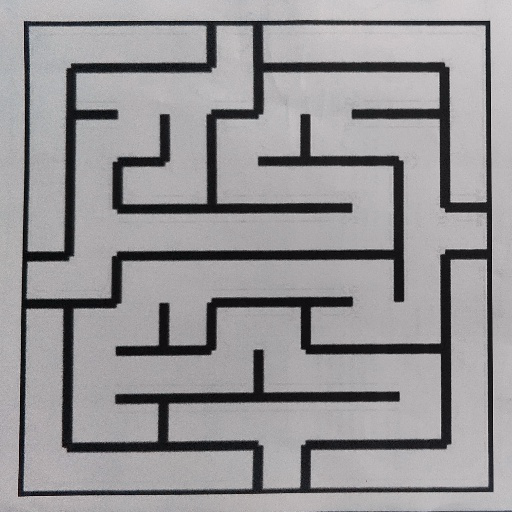

[[[511 510]]

 [[ 24  21]]

 [[ 18 496]]

 [[493 491]]

 [[488  20]]

 [[111  19]]]
24 21 488 20 493 491 18 496


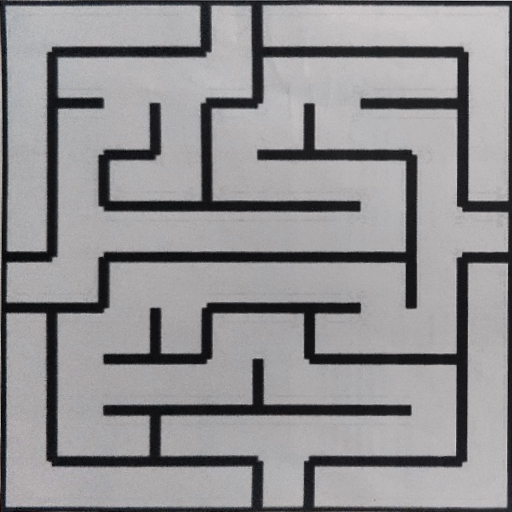

[[3, 10, 10, 14, 7, 11, 10, 10, 10, 6], [5, 11, 2, 2, 12, 3, 2, 10, 14, 5], [5, 3, 12, 5, 3, 12, 9, 10, 6, 5], [5, 5, 11, 12, 9, 10, 10, 6, 5, 13], [13, 1, 10, 10, 10, 10, 10, 12, 1, 14], [11, 12, 3, 2, 10, 10, 10, 6, 5, 7], [7, 3, 12, 13, 3, 6, 11, 8, 12, 5], [5, 1, 10, 10, 12, 9, 10, 10, 6, 5], [5, 9, 14, 11, 10, 2, 10, 10, 12, 5], [9, 10, 10, 10, 14, 13, 11, 10, 10, 12]]
[(14, 576), (168, 576), (168, 446), (168, 311), (311, 311), (311, 168), (446, 168), (576, 168), (576, 311), (576, 446), (576, 576), (576, 704), (576, 834), (576, 969), (446, 969), (446, 834), (446, 704), (446, 576), (311, 576), (311, 704), (168, 704), (168, 834), (311, 834), (311, 969), (311, 1112), (446, 1112), (576, 1112), (704, 1112), (834, 1112), (834, 969), (704, 969), (704, 834), (704, 704), (704, 576), (704, 446), (704, 311), (834, 311), (834, 168), (969, 168), (969, 311), (969, 446), (969, 576), (834, 576), (834, 704), (969, 704), (969, 834), (969, 969), (969, 1112), (1112, 1112), (1112, 969), (1112, 834), (

In [22]:
file_num = input("Enter Maze Number: ")
img_file_path = 'test_cases/maze0'+ str(file_num) + '.jpg'
maze_name = 'maze0' + str(file_num)

# read start and end coordinates from json file
start_coord, end_coord = read_start_end_coordinates("start_end_coordinates.json", maze_name)

# read the 'maze00.jpg' image file
input_img = cv2.imread(img_file_path)
display(Image.fromarray(input_img))
# get the resultant warped maze image after applying Perspective Transform
warped_img = applyPerspectiveTransform(input_img)

display(Image.fromarray(warped_img))
maze_array = detectMaze(warped_img)
print(maze_array)

path = find_path(maze_array, start_coord, end_coord)

pixel_path = convert_path_to_pixels(path)

print(pixel_path)

### Drawing Path:

In [23]:
#start_simulation()
#init_setup()
send_data_to_draw_path(client_id, path)



Path sent to drawPath function of Lua script is 

[-0.45, -0.05, -0.35, -0.05, -0.35, -0.15, -0.35, -0.25, -0.25, -0.25, -0.25, -0.35, -0.15, -0.35, -0.05, -0.35, -0.05, -0.25, -0.05, -0.15, -0.05, -0.05, -0.05, 0.05, -0.05, 0.15, -0.05, 0.25, -0.15, 0.25, -0.15, 0.15, -0.15, 0.05, -0.15, -0.05, -0.25, -0.05, -0.25, 0.05, -0.35, 0.05, -0.35, 0.15, -0.25, 0.15, -0.25, 0.25, -0.25, 0.35, -0.15, 0.35, -0.05, 0.35, 0.05, 0.35, 0.15, 0.35, 0.15, 0.25, 0.05, 0.25, 0.05, 0.15, 0.05, 0.05, 0.05, -0.05, 0.05, -0.15, 0.05, -0.25, 0.15, -0.25, 0.15, -0.35, 0.25, -0.35, 0.25, -0.25, 0.25, -0.15, 0.25, -0.05, 0.15, -0.05, 0.15, 0.05, 0.25, 0.05, 0.25, 0.15, 0.25, 0.25, 0.25, 0.35, 0.35, 0.35, 0.35, 0.25, 0.35, 0.15, 0.35, 0.05, 0.45, 0.05]


## Maze Generation Testing:

In [24]:
img_path = input("Enter Maze Number: ")
image = cv2.imread("test_cases/" + "maze0" + img_path + ".jpg")
warped_img = applyPerspectiveTransform(image)
display(Image.fromarray(warped_img))
maze_array = detectMaze(warped_img)

client_id = init_remote_api_server()

send_data(client_id, maze_array)

KeyboardInterrupt: Interrupted by user

In [ ]:
print(maze_array)

## Generate Maze, then Drawing Path:

In [ ]:
file_num = input("Enter Maze Number: ")
input_img = cv2.imread("test_cases/" + "maze0" + file_num + ".jpg")
#display(Image.fromarray(input_img))

warped_img = applyPerspectiveTransform(input_img)
display(Image.fromarray(warped_img))
maze_array = detectMaze(warped_img)
#print(maze_array)

client_id = init_remote_api_server()

send_data(client_id, maze_array)

maze_name = 'maze0' + str(file_num)

# read start and end coordinates from json file
start_coord, end_coord = read_start_end_coordinates("start_end_coordinates.json", maze_name)
path = find_path(maze_array, start_coord, end_coord)
#print(path)

start_simulation()
init_setup(client_id)
send_data_to_draw_path(client_id, path)

In [ ]:
print(path)

## Full Solution:

In [ ]:
file_num = input("Enter Maze Number: ")
input_img = cv2.imread("test_cases/" + "maze0" + file_num + ".jpg")
#display(Image.fromarray(input_img))

warped_img = applyPerspectiveTransform(input_img)
display(Image.fromarray(warped_img))
maze_array = detectMaze(warped_img)
#print(maze_array)

client_id = init_remote_api_server()

send_data(client_id, maze_array)

maze_name = 'maze0' + str(file_num)

# read start and end coordinates from json file
start_coord, end_coord = read_start_end_coordinates("start_end_coordinates.json", maze_name)
path = find_path(maze_array, start_coord, end_coord)
#print(path)

start_simulation()
init_setup(client_id)
send_data_to_draw_path(client_id, path)

pixel_path = convert_path_to_pixels(path)
traverse_path(pixel_path)